### This was done for titanic kaggle competition in 2017
I am in the top 7 percentile in this kaggle competition
I think the most important feature I added was the grouping of travelers having the same ticket number
I used many classifiers with cross validations to get the best model...the best performing was the random forest (better than SVM and the others)
Some visualizations were done using seaborn and matplotlib to analyze the data 

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
import scipy
%matplotlib inline

import seaborn as sns

In [10]:
#def importmodels ():
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA

In [11]:
from sklearn.model_selection import train_test_split


In [ ]:
import pydot
from sklearn.externals.six import StringIO
import pydotplus

from sklearn import tree

# Imported all


# import training data and create titanic_train_df

In [12]:
titanic_train_df= pd.DataFrame()
def readcsv(file):
    global titanic_train_df
    titanic_train_df=pd.read_csv(file)


In [13]:
readcsv('train.csv')
titanic_train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Some analysis

In [14]:
np.cov(titanic_train_df['Pclass'],titanic_train_df.Survived)



array([[ 0.69901512, -0.13770287],
       [-0.13770287,  0.23677222]])

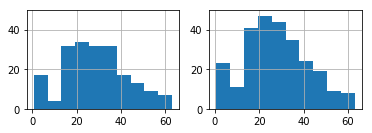

In [27]:
fig = plt.figure()

ax1 = fig.add_subplot(221)
plt.ylim(0,50)
((titanic_train_df[(titanic_train_df['Survived']==1) & (titanic_train_df['Sex']=='female')]).Age).hist()
ax1 = fig.add_subplot(222)
plt.ylim(0,50)
(titanic_train_df[(titanic_train_df['Sex']=='female')]).Age.hist()

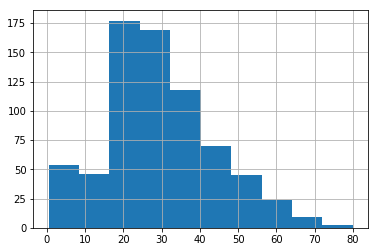

In [29]:
%matplotlib inline  
titanic_train_df.Age.hist()

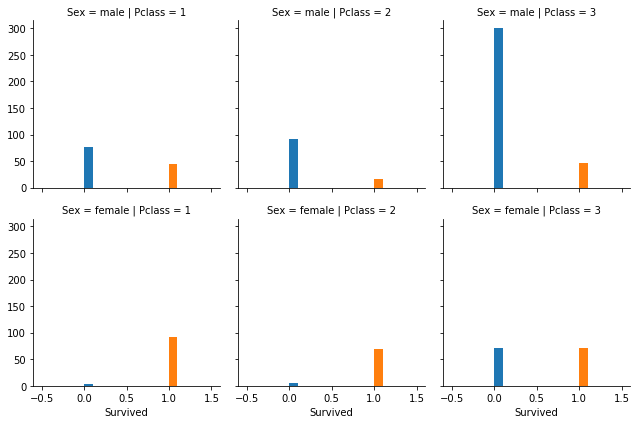

In [15]:
import matplotlib.pyplot as plt
g = sns.FacetGrid(titanic_train_df, col="Pclass",  row="Sex",hue='Survived')
g = g.map(plt.hist, "Survived")

- convert tickets with string value to int
- make sure to take into account different formats of tickets and take the number of the ticket only
- Put women and children (From all the titles extracted from name field) into one field,

In [16]:

tick=[]
tick=titanic_train_df.Ticket
tick=tick.replace(['LINE'],'5000000')
tick=tick.replace(['Basle'],'5110000')
newticket=[]
for i in tick:
	try:
		x=i.split(' ')
		if len(x)>2:
			newticket.append(x[2])
		elif len(x)==2:
			newticket.append(x[1])
		else:
			newticket.append(x[0])
	except:
		newticket.append(i)
		print("except")
#newticket

#new ticket and newticket 2 as well
newticket2=[0] * len(newticket)
for i in range(0,len(newticket)):
	if (newticket.count(newticket[i])<2):
		newticket2[i]=int(newticket[i])/1000
		newticket[i]=700000


total=titanic_train_df.assign(newticket=newticket)
total=total.assign(newticket2=newticket2)
total=total.assign(sp=total.SibSp+total.Parch)
#newticket
total=total[["PassengerId","Pclass","Name","sp","Survived","newticket","newticket2"]]
print(total.head())
namelist=[]
for x in total.Name:
	y=x.split(',')
	z=y[1].split('.')
	namelist.append(z[0])

total=total.assign(titles=namelist)
total.titles=total.titles.str.strip()

total.titles=total.titles.replace(['Dona', 'Lady','Mme','Ms','the Countess','Mlle','Mrs','Miss','Master'], 'WNC')
total.titles=total.titles.replace(['Don', 'Rev','Major','Sir','Col','Capt','Jonkheer','Dr'], 'Mr')


total=total.drop(['Name','newticket2','PassengerId'],axis=1)

   PassengerId  Pclass                                               Name  sp  \
0            1       3                            Braund, Mr. Owen Harris   1   
1            2       1  Cumings, Mrs. John Bradley (Florence Briggs Th...   1   
2            3       3                             Heikkinen, Miss. Laina   0   
3            4       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   1   
4            5       3                           Allen, Mr. William Henry   0   

   Survived newticket  newticket2  
0         0    700000      21.171  
1         1    700000      17.599  
2         1    700000    3101.282  
3         1    113803       0.000  
4         0    700000     373.450  


In [17]:
total.columns

Index(['Pclass', 'sp', 'Survived', 'newticket', 'titles'], dtype='object')

In [18]:
#drop 70000
missed=0
totalcount=0
temptotal=total[total.newticket!=700000]
for ticket in temptotal.newticket.unique().tolist():
    for title in temptotal.titles:
        condition=(temptotal.newticket==ticket) & (temptotal.titles==title)
        cutted=temptotal[condition]
        tempsurv=len(cutted.Survived[cutted.Survived==1])
        tempusurv=len(cutted.Survived[cutted.Survived==0])
        if (tempsurv >0) & (tempusurv >0):
            missed=missed+tempsurv + tempusurv
            totalcount=totalcount+tempsurv + tempusurv
        else:
            totalcount=totalcount+tempsurv + tempusurv
print(totalcount)
unseparatedpercentage=missed/totalcount

64165


In [19]:
missed

3937

In [20]:
temptotal.newticket.unique().tolist()

['113803',
 '349909',
 '347742',
 '237736',
 '9549',
 '347082',
 '382652',
 '239865',
 '347077',
 '19950',
 '17569',
 '17604',
 '113789',
 '345764',
 '2651',
 '11668',
 '2123',
 '349237',
 '3101295',
 '17572',
 '34651',
 '2144',
 '113572',
 '36973',
 '347088',
 '2661',
 '14879',
 '1601',
 '248738',
 '364516',
 '3101278',
 '6608',
 '2315',
 '231919',
 '244367',
 '35281',
 '371110',
 '110465',
 '2665',
 '2627',
 '17558',
 '2668',
 '7534',
 '17593',
 '2678',
 '3101279',
 '33112',
 '230080',
 '113776',
 '2343',
 '363291',
 '113505',
 '4133',
 '5000000',
 '230136',
 '370365',
 '364849',
 '347054',
 '2699',
 '35273',
 '243847',
 '19943',
 '751',
 '31921',
 '367230',
 '19928',
 '250649',
 '11751',
 '244252',
 '3336',
 '370129',
 '110152',
 '17755',
 '230433',
 '110413',
 '17582',
 '17760',
 '113798',
 '250644',
 '13502',
 '239853',
 '2673',
 '19877',
 '11967',
 '113781',
 '367226',
 '17421',
 '17758',
 '3381',
 '17485',
 '11767',
 '17608',
 '13529',
 '36928',
 '16966',
 '111361',
 '17611',
 '

In [21]:
temptotal=total[total.newticket!=700000]
temptotal.head()

,Pclass,sp,Survived,newticket,titles
3,1,1,1,113803,WNC
7,3,4,0,349909,WNC
8,3,2,1,347742,WNC
9,2,1,1,237736,WNC
10,3,2,1,9549,WNC


In [22]:
len(temptotal[(temptotal.newticket=='9549') & (temptotal.titles=='WNC')].Survived[temptotal.Survived==1])

2

- An example of members of one ticket travelling togther

In [24]:
total[total.newticket=='113781']

,Pclass,sp,Survived,newticket,titles
297,1,3,0,113781,WNC
305,1,3,1,113781,WNC
498,1,3,0,113781,WNC
708,1,0,1,113781,WNC


In [25]:
titanic_train_df[titanic_train_df.Ticket=='113781']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
297,298,0,1,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.55,C22 C26,S
305,306,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.55,C22 C26,S
498,499,0,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.55,C22 C26,S
708,709,1,1,"Cleaver, Miss. Alice",female,22.00,0,0,113781,151.55,NaN,S


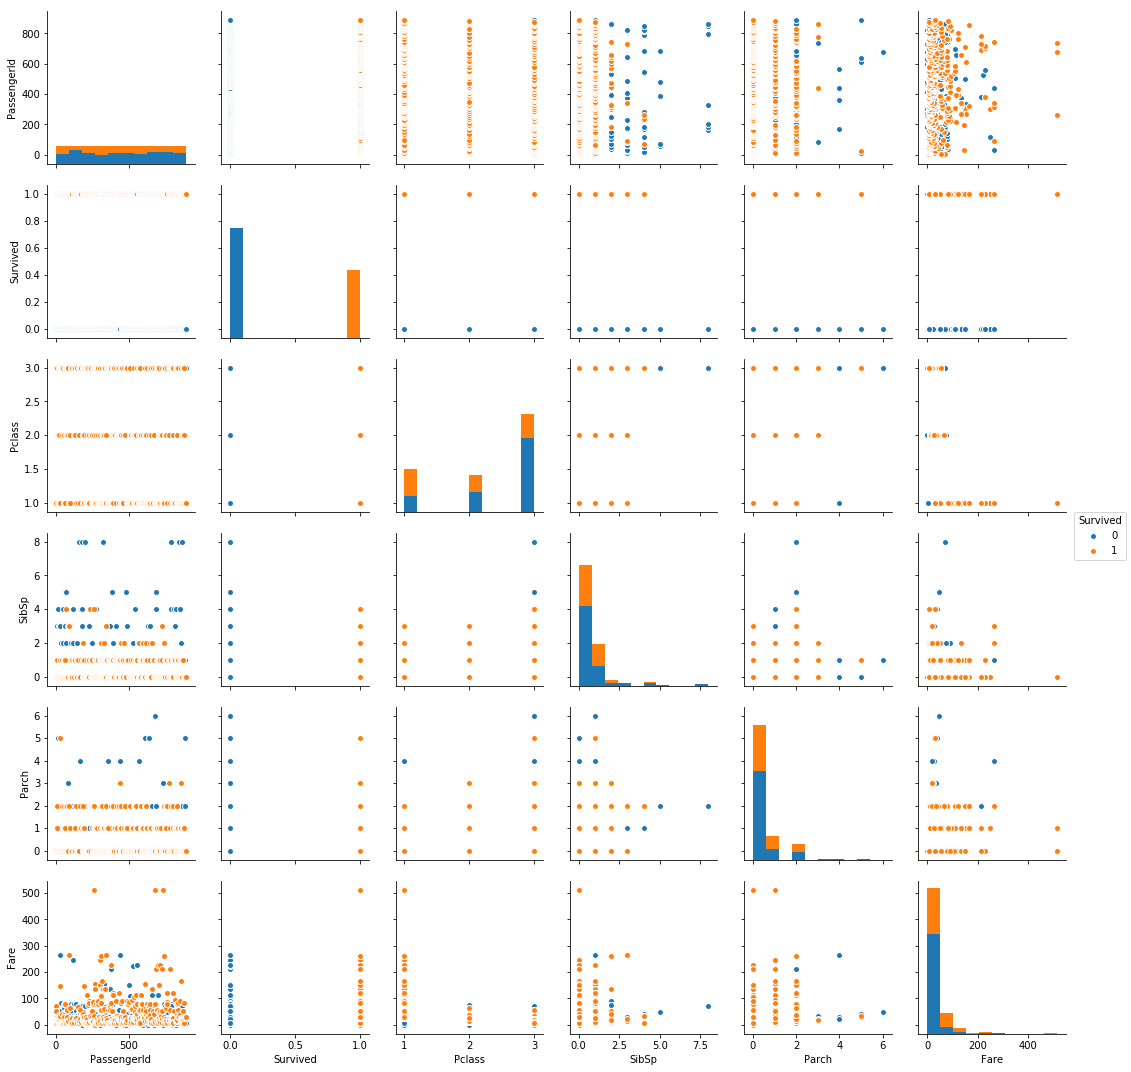

In [10]:
sns.pairplot(titanic_train_df.drop("Cabin", axis=1).drop("Age",axis=1),hue="Survived")

In [ ]:
sns.pairplot(titanic_train_df.drop("Cabin", axis=1).drop("Age",axis=1),hue="Survived")

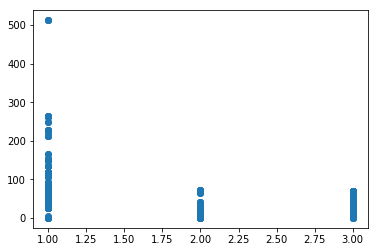

In [17]:
plt.plot(titanic_train_df.Pclass,titanic_train_df.Fare,'o')

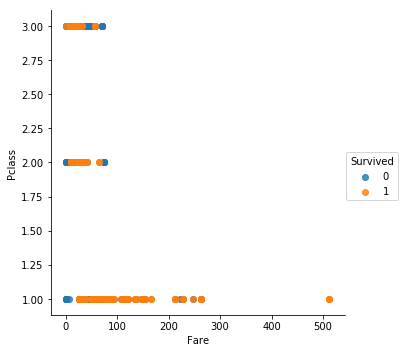

In [26]:
from matplotlib import rc
sns.lmplot(x="Fare",y="Pclass",hue="Survived",data=titanic_train_df,
           fit_reg=False)

In [30]:
titles=["Mrs","Mr\.","Master","Miss"]

# use titanic_train_df to create a new variable tito_titles 
Without changing original titanic_train_df

In [31]:
def getfirstcharCabin():
    cabin=titanic_train_df.Cabin
    cabintemp=[]
    for i in cabin:
        #print i
        try:
            cabintemp.append(i[0])
        except TypeError:
            cabintemp.append('None')
    return cabintemp

In [32]:
cabinchar=getfirstcharCabin()

In [33]:
def createnewcols():
    train_df=titanic_train_df
    don_list=train_df['Name'].str.contains("Don\.")*1
    mrs_list=train_df['Name'].str.contains("Mrs")*1
    mr_list=train_df['Name'].str.contains("Mr\.")*1
    master_list=train_df['Name'].str.contains("Master")*1
    miss_list=train_df['Name'].str.contains("Miss")*1
    rev_list=train_df['Name'].str.contains("Rev\.")*1
    dr_list=train_df['Name'].str.contains("Dr\.")*1
    mme_list=train_df['Name'].str.contains("Mme\.")*1
    lady_list=train_df['Name'].str.contains("Lady\.")*1
    sir_list=train_df['Name'].str.contains("Sir\.")*1
    jr_list=train_df['Name'].str.contains("Jr")*1
    mlle_list=train_df['Name'].str.contains("Mlle\.")*1
    col_list=train_df['Name'].str.contains("Col\.")*1
    capt_list=train_df['Name'].str.contains("Capt\.")*1
    countess_list=train_df['Name'].str.contains("Countess\.")*1
    jonkheer_list=train_df['Name'].str.contains("Jonkheer\.")*1
    
    train_df_titles=train_df.assign(Jonkheer=jonkheer_list).assign(Countess=countess_list).assign(Capt=capt_list).assign(Col=col_list).assign(Mlle=mlle_list).assign(Sir=sir_list).assign(Lady=lady_list).assign(Mme=mme_list).assign(Dr=dr_list).assign(Rev=rev_list).assign(Don=don_list).assign(Mrs=mrs_list).assign(Mr=mr_list).assign(Master=master_list).assign(Miss=miss_list)
    train_df_titles=pd.get_dummies(train_df_titles,columns=['Sex'],prefix=['sex'])
    train_df_titles=pd.get_dummies(train_df_titles,columns=['Embarked'],prefix=['embarked'])
    sibspparch=train_df_titles['SibSp']+train_df_titles['Parch']
    train_df_titles=train_df_titles.assign(sibspparch=sibspparch)
    train_df_titles=train_df_titles.assign(cabinchar=getfirstcharCabin())
    train_df_titles=pd.get_dummies(train_df_titles,columns=['cabinchar'],prefix=['cabinchar'])
    return train_df_titles

In [34]:
tito_titles=createnewcols()

In [35]:
tito_titles.isnull().sum()

PassengerId         0
Survived            0
Pclass              0
Name                0
Age               177
SibSp               0
Parch               0
Ticket              0
Fare                0
Cabin             687
Jonkheer            0
Countess            0
Capt                0
Col                 0
Mlle                0
Sir                 0
Lady                0
Mme                 0
Dr                  0
Rev                 0
Don                 0
Mrs                 0
Mr                  0
Master              0
Miss                0
sex_female          0
sex_male            0
embarked_C          0
embarked_Q          0
embarked_S          0
sibspparch          0
cabinchar_A         0
cabinchar_B         0
cabinchar_C         0
cabinchar_D         0
cabinchar_E         0
cabinchar_F         0
cabinchar_G         0
cabinchar_None      0
cabinchar_T         0
dtype: int64

In [36]:
len(tito_titles.columns)

40

# create new variable tito_drop
from tito_titles without changing titles var

In [37]:
tito_drop=tito_titles.drop(['Name','Ticket','Cabin','Age'],axis=1)

In [38]:
len(tito_drop.columns)

36

# Create train and test 

In [39]:
X_train, X_test, y_train, y_test = train_test_split(tito_drop.drop(['Survived'],axis=1), tito_drop.Survived, test_size=0.13, random_state=42)

In [40]:
len(X_test)

116

In [41]:
X_test.columns

Index(['PassengerId', 'Pclass', 'SibSp', 'Parch', 'Fare', 'Jonkheer',
       'Countess', 'Capt', 'Col', 'Mlle', 'Sir', 'Lady', 'Mme', 'Dr', 'Rev',
       'Don', 'Mrs', 'Mr', 'Master', 'Miss', 'sex_female', 'sex_male',
       'embarked_C', 'embarked_Q', 'embarked_S', 'sibspparch', 'cabinchar_A',
       'cabinchar_B', 'cabinchar_C', 'cabinchar_D', 'cabinchar_E',
       'cabinchar_F', 'cabinchar_G', 'cabinchar_None', 'cabinchar_T'],
      dtype='object')

# Classifiers

## Decision Tree

In [43]:
def dtmodel(xl,yl):
    t0=time()
    param_grid=dict(min_samples_split=range(5,150,10))
    dt=DecisionTreeClassifier(random_state=300)
    grid_dt_titan=GridSearchCV(dt,param_grid,cv=10,scoring='accuracy')
    grid_dt_titan.fit(xl,yl)
    #print(grid_dt_titan.grid_scores_)
    print("And the oscar goes to: ")
    print(grid_dt_titan.best_score_)
    print("with: ")
    print(grid_dt_titan.best_params_)
    t1=time()
    print("In: ",t1-t0," sec.")

In [44]:
dtmodel(X_train.drop(['PassengerId'],axis=1),y_train)

And the oscar goes to: 
0.828387096774
with: 
{'min_samples_split': 105}
In:  0.4497840404510498  sec.


- dt v2

In [53]:
dt2=DecisionTreeClassifier(random_state=300,min_samples_split=105)
dt2.fit(X_train.drop(['cabinchar_T','PassengerId'],axis=1),y_train)
print(dt2.feature_importances_)
print(dt2.n_features_ )
#print(tito_drop.drop(['Survived','cabinchar_T'],axis=1).columns)

[ 0.15014005  0.          0.          0.08378826  0.          0.
  0.00942573  0.00430479  0.          0.          0.          0.          0.0187022
  0.04339456  0.          0.          0.58181793  0.          0.          0.
  0.01361612  0.00293834  0.          0.          0.08358944  0.          0.
  0.00150771  0.00336775  0.00340714  0.          0.          0.        ]
33


In [54]:
predicted=dt2.predict(X_test.drop(['cabinchar_T','PassengerId'],axis=1))
accuracy_score(predicted,y_test)

0.83620689655172409

- random forest

In [56]:
rf2=RandomForestClassifier(random_state=300,n_estimators=107,max_depth=9)
rf2.fit(X_train.drop(['PassengerId'],axis=1),y_train)
print(rf2.feature_importances_)
print(rf2.n_features_ )
print(tito_drop.drop(['Survived','PassengerId'],axis=1).columns)

[  8.02949205e-02   4.45437368e-02   3.23912387e-02   1.77233906e-01
   0.00000000e+00   1.65669988e-04   1.28575627e-03   7.38367769e-04
   1.90965786e-04   1.07901746e-03   1.99364866e-04   4.31103091e-06
   3.02694749e-03   4.27594201e-03   0.00000000e+00   3.15355623e-02
   1.46883832e-01   1.98257779e-02   3.27298358e-02   1.22758706e-01
   1.14221370e-01   1.62532452e-02   8.70445021e-03   1.57816894e-02
   6.69134226e-02   2.41282443e-03   1.12256005e-02   8.73643649e-03
   8.54484062e-03   1.30719586e-02   3.48612653e-03   2.12571443e-03
   2.89706140e-02   3.87848202e-04]
34
Index(['Pclass', 'SibSp', 'Parch', 'Fare', 'Jonkheer', 'Countess', 'Capt',
       'Col', 'Mlle', 'Sir', 'Lady', 'Mme', 'Dr', 'Rev', 'Don', 'Mrs', 'Mr',
       'Master', 'Miss', 'sex_female', 'sex_male', 'embarked_C', 'embarked_Q',
       'embarked_S', 'sibspparch', 'cabinchar_A', 'cabinchar_B', 'cabinchar_C',
       'cabinchar_D', 'cabinchar_E', 'cabinchar_F', 'cabinchar_G',
       'cabinchar_None', 'cabin

In [57]:
predicted_rf=rf2.predict(X_test.drop('PassengerId',axis=1))
accuracy_score(predicted_rf,y_test)

0.81034482758620685

In [58]:
rf2

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=9, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=107, n_jobs=1,
            oob_score=False, random_state=300, verbose=0, warm_start=False)

- random forest v2

In [62]:
def rfmodel2(xl,yl):
    
    t0=time()
    #min_samples_split=range(3,120),
    param_grid=dict(max_depth=range(4,10),n_estimators=list(range(99,150))+[500,1000])

    #svm=SVC()
    rf=RandomForestClassifier(random_state=423)
    grid_rf_titan=GridSearchCV(rf,param_grid,cv=10,scoring='accuracy',n_jobs=6)

    #titanic
    grid_rf_titan.fit(xl.drop(['PassengerId'],axis=1),yl)

   # print(grid_rf_titan.grid_scores_)
    print("And the oscar goes to: ")
    print(grid_rf_titan.best_score_)
    print("with parameters: ")
    print(grid_rf_titan.best_params_)
    t1=time()
    print("In: ",t1-t0," s.")


In [63]:
rfmodel2(X_train,y_train)

And the oscar goes to: 
0.833548387097
with parameters: 
{'max_depth': 5, 'n_estimators': 139}
In:  212.22578406333923  s.


- Check the tree as pdf

In [115]:
dot_data=StringIO()
tree.export_graphviz(dt2,
                     out_file=dot_data,
                     feature_names=X_train.drop(['cabinchar_T','PassengerId'],axis=1).columns,
                     class_names=["n","y"],
                     filled=True, rounded=True, impurity=False)
graph=pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_pdf("tiitanic-nopassidDT.pdf")


True

- SVM

In [68]:
from time import time
t0=time()
#svm_cs= [1,10,10000,500000]
#svm_gammas=[0.33,1,10,100]
svm_cs= [1,10,1000,10000,50000]
svm_gammas=list(reversed([0.05]+[(1/float(x)) for x in range(1,7,2)]))+[10**x for x in range(1,7,2)]
param_grid=dict(C=svm_cs,gamma=svm_gammas)
svm=SVC()

grid=GridSearchCV(svm,param_grid,cv=10,scoring='accuracy')
#grid.fit(iris_f,iris_cat)
#Titanic SVM 
grid.fit(X_train,y_train)
#print(grid.cv_results_)
#print(grid.grid_scores_)
print("And the oscar goes to: ")
print(grid.best_score_)
print ("with params: ")
print(grid.best_params_)
t1=time()
print("In: ",t1-t0," s.")

And the oscar goes to: 
0.61935483871
with params: 
{'C': 1, 'gamma': 1.0}
In:  18.560485124588013  s.


- AdaBoostClassifier

In [74]:
from time import time
t0=time()
#svm_cs= [1,10,10000,500000]
#svm_gammas=[0.33,1,10,100]
#svm_cs= [1,10,100,1000,10000,50000,100000,500000,1000000]
#svm_gammas=list(reversed([0.01,0.05]+[(1/float(x)) for x in range(1,7)]))+[10**x for x in range(1,7)]
param_grid=dict(min_samples_split=range(5,100,5))
param_grid=dict(n_estimators=range(5,100,5))

#svm=SVC()
dt=AdaBoostClassifier()
grid=GridSearchCV(dt,param_grid,cv=10,scoring='accuracy')



#titanic
grid.fit(X_train,y_train)

#grid.fit(iris_f,iris_cat)


#print(grid.cv_results_)
#print(grid.grid_scores_)
print("And the oscar goes to: ")
print(grid.best_score_)
print ("with param: ")
print(grid.best_params_)
t1=time()
print("In: ",t1-t0," s.")

And the oscar goes to: 
0.814193548387
with param: 
{'n_estimators': 5}
In:  12.95722222328186  s.


- KNN

In [76]:

from time import time
t0=time()
#svm_cs= [1,10,10000,500000]
#svm_gammas=[0.33,1,10,100]
#svm_cs= [1,10,100,1000,10000,50000,100000,500000,1000000]
#svm_gammas=list(reversed([0.01,0.05]+[(1/float(x)) for x in range(1,7)]))+[10**x for x in range(1,7)]
param_grid=dict(n_neighbors=range(3,20))
#param_grid=dict(n_estimators=range(5,100,5))

#svm=SVC()
dt=KNeighborsClassifier()
grid=GridSearchCV(dt,param_grid,cv=10,scoring='accuracy')

#titanic
grid.fit(X_train,y_train)

#grid.fit(iris_f,iris_cat)

#print(grid.cv_results_)
#print(grid.grid_scores_)
print("And the oscar goes to: ")
print(grid.best_score_)
print ("with k neighbors : ")
print(grid.best_params_)
t1=time()
print("In: ",t1-t0," s.")

And the oscar goes to: 
0.655483870968
with k neighbors : 
{'n_neighbors': 17}
In:  1.7268221378326416  s.


- KNN with minmax scaler

In [78]:
from sklearn.preprocessing import MinMaxScaler


from time import time
t0=time()
#svm_cs= [1,10,10000,500000]
#svm_gammas=[0.33,1,10,100]
#svm_cs= [1,10,100,1000,10000,50000,100000,500000,1000000]
#svm_gammas=list(reversed([0.01,0.05]+[(1/float(x)) for x in range(1,7)]))+[10**x for x in range(1,7)]
param_grid=dict(n_neighbors=range(2,10),leaf_size=range(10,41))
#param_grid=dict(n_estimators=range(5,100,5))
scaler = MinMaxScaler()
#iris_f2= scaler.fit_transform(iris_f)
#titanic scaling

train_tit4_scale= scaler.fit_transform(X_train)
#svm=SVC()
dt=KNeighborsClassifier()
grid=GridSearchCV(dt,param_grid,cv=10,scoring='accuracy')

#titanic
grid.fit(train_tit4_scale,y_train)

#grid.fit(iris_f,iris_cat)

#print(grid.cv_results_)
#print(grid.grid_scores_)
print("And the oscar goes to: ")
print(grid.best_score_)
print( "with params: ")
print(grid.best_params_)
t1=time()
print("In: ",t1-t0," s.")

And the oscar goes to: 
0.812903225806
with params: 
{'leaf_size': 10, 'n_neighbors': 8}
In:  43.43093514442444  s.
